In [161]:
import gquant
import abupy
import QUANTAXIS as QA

gquant.plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文显示问题-设置字体为黑体
gquant.plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

# 原始数据

In [2]:
# 原始未复权数据
ori_data_df = gquant.pd.read_csv('300378_daily.csv', 
                                 encoding='utf-8', 
                                 parse_dates=[0], 
                                 dtype={'code': str}).set_index(['date', 'code'])
ori_data = QA.QAData.QA_DataStruct_Stock_day(ori_data_df)
# 前复权数据
ori_data_df_qfq = ori_data.to_qfq().data

# 数据初始化

In [30]:
class LocalDataAPI(abupy.MarketBu.ABuDataBase.StockBaseMarket, abupy.MarketBu.ABuDataBase.SupportMixin):
    def _support_market(self):
        """声明数据源支持A股"""
        return [abupy.EMarketTargetType.E_MARKET_TARGET_CN]

    def kline(self, n_folds=2, start=None, end=None, fq='01'):
        df = ori_data_df_qfq.copy()
        df['pre_close']=df['close'].shift()
        df['date'] = df.index.get_level_values(0)
        df['date'] = df['date'].dt.strftime(
            '%Y%m%d').apply(lambda x: abupy.ABuDateUtil.date_str_to_int(x))
        df.index = df.index.droplevel(1)
        df.index.name = 'dt'
        df['date_week'] = df.index.dayofweek
        return df

    def minute(self, n_fold=5, *args, **kwargs):
        """分钟k线接口"""
        raise NotImplementedError('QAApi minute NotImplementedError!')

In [31]:
abupy.env.g_market_target = abupy.env.EMarketTargetType.E_MARKET_TARGET_CN
# 所有任务数据强制网络更新
abupy.env.g_data_fetch_mode = abupy.env.EMarketDataFetchMode.E_DATA_FETCH_FORCE_NET
# 使用QUATAXIS本地数据作为数据源
abupy.env.g_private_data_source = LocalDataAPI

In [19]:
# symbol = abupy.ABuMarket.code_to_symbol('sz300378')
# df = LocalDataAPI(symbol).kline()
# df

In [205]:
from abupy.IndicatorBu.ABuNDAtr import calc_atr
from QUANTAXIS.QAIndicator.talib_series import BBANDS


class KLManager(abupy.AbuKLManager):
    def _fetch_pick_time_kl_pd(self, target_symbol):
        data = abupy.MarketBu.ABuSymbolPd.make_kl_df(target_symbol)
        if not data.empty:
            high = data['high']
            low = data['low']
            pre_close = data['pre_close']
            data['atr5'] = calc_atr(high, low, pre_close, 5)
            data['atr10'] = calc_atr(high, low, pre_close, 10)
            data['atr20'] = calc_atr(high, low, pre_close, 20)
            data['atr14'] = calc_atr(high, low, pre_close, 14)
            data['atr21'] = calc_atr(high, low, pre_close, 21)
            data['sar'] = gquant.Indicator.calc_sar(data, 0.1, 0.5)  # 抛物线指标
            data['bbup'], data['bbmid'], data['bblow'] = BBANDS(data.close,
                                                                timeperiod=30,
                                                                nbdevup=1.5,
                                                                nbdevdn=1.5,
                                                                matype=0)
        result = data[self.benchmark.start:self.benchmark.end]
        result.name = data.name
        return result

## 初始化数据读取示例

In [6]:
# 沪深300指数
benchmark=gquant.abupy.TradeBu.ABuBenchmark.AbuBenchmark(benchmark='000300', start='2014-01-01', end='2019-12-31')
# 资金管理。使用默认的手续费计算方法
capital=gquant.abupy.TradeBu.ABuCapital.AbuCapital(10000,benchmark,)

In [34]:
# abupy.MarketBu.ABuSymbolPd.make_kl_df('300378')

# 模拟测试

In [198]:
def simple_test(data):
    # 绘制完整布林带买卖盈亏示例
    data[['close', 'bbup', 'bbmid', 'bblow']].plot(figsize=(50,10))
    gquant.plt.plot(data[data['buy'] == 1]['close'], 'ro')
    gquant.plt.plot(data[data['sell'] == 1]['close'], 'go')
    last_buy=[]
    simple_profit=[]#盈亏示例
    for index,row in data.iterrows():
        if row['buy']==1:
            last_buy.append(index)
            continue
        if row['sell']==1:
            while last_buy:
                b=last_buy.pop(0)
                buy_close=data['close'][b]
                sell_close=data['close'][index]
                pf=(sell_close-buy_close)/buy_close#交易盈亏率
                data.loc[b:index,'close'].plot.area(color='g' if sell_close<=buy_close else 'r', alpha=0.5)
                gquant.plt.annotate('{:.2f}'.format(pf),(b,buy_close), fontsize=16)
                simple_profit.append(pf)
    gquant.plt.show()
    
    # 绘制单次盈亏比率柱状图
    simple_profit=gquant.pd.Series(simple_profit)
    simple_profit.round(2).sort_index().plot(kind='bar',figsize=(5,3),title='单次盈亏比率')
    gquant.plt.show()
    
    # 绘制盈亏占比饼图
    gquant.pd.Series(gquant.np.sign(simple_profit)).value_counts().plot(kind='pie', autopct='%1.1f%%',figsize=(5,3),title='盈亏次数占比')
    gquant.plt.show()
    
    print('盈利交易平均盈利比率:{:.2%}\n最大盈利比率:{:.2%}\n亏损交易平均亏损比率:{:.2%}\n最大亏损比率:{:.2%}\n平均:{:.2%}\n交易次数:{}'.format(
    simple_profit[simple_profit > 0].mean(),simple_profit.max(), simple_profit[simple_profit <= 0].mean(), simple_profit.min(),simple_profit.mean(),simple_profit.count()))

## 简单布林带穿越上轨（买入）/中轨（卖出）

- 收盘价上穿布林带上轨（买入）
- 收盘价下穿布林带中轨（卖出）

默认使用30日线，上下1.5倍标准差

测试了2014~2019年之间的数据。

- 盈利交易平均盈利比率:26.25%
- 最大盈利比率:72.69%
- 亏损交易平均亏损比率:-6.18%
- 最大亏损比率:-12.46%
- 平均:6.90%
- 交易次数:57

**问题**： 此计算方式并不准确，仅做示例参考。因为：

1. 以当日收盘价作为判断依据的同时，以当日作为建仓或清仓标准是不合理的。
2. 没有考虑交易手续费

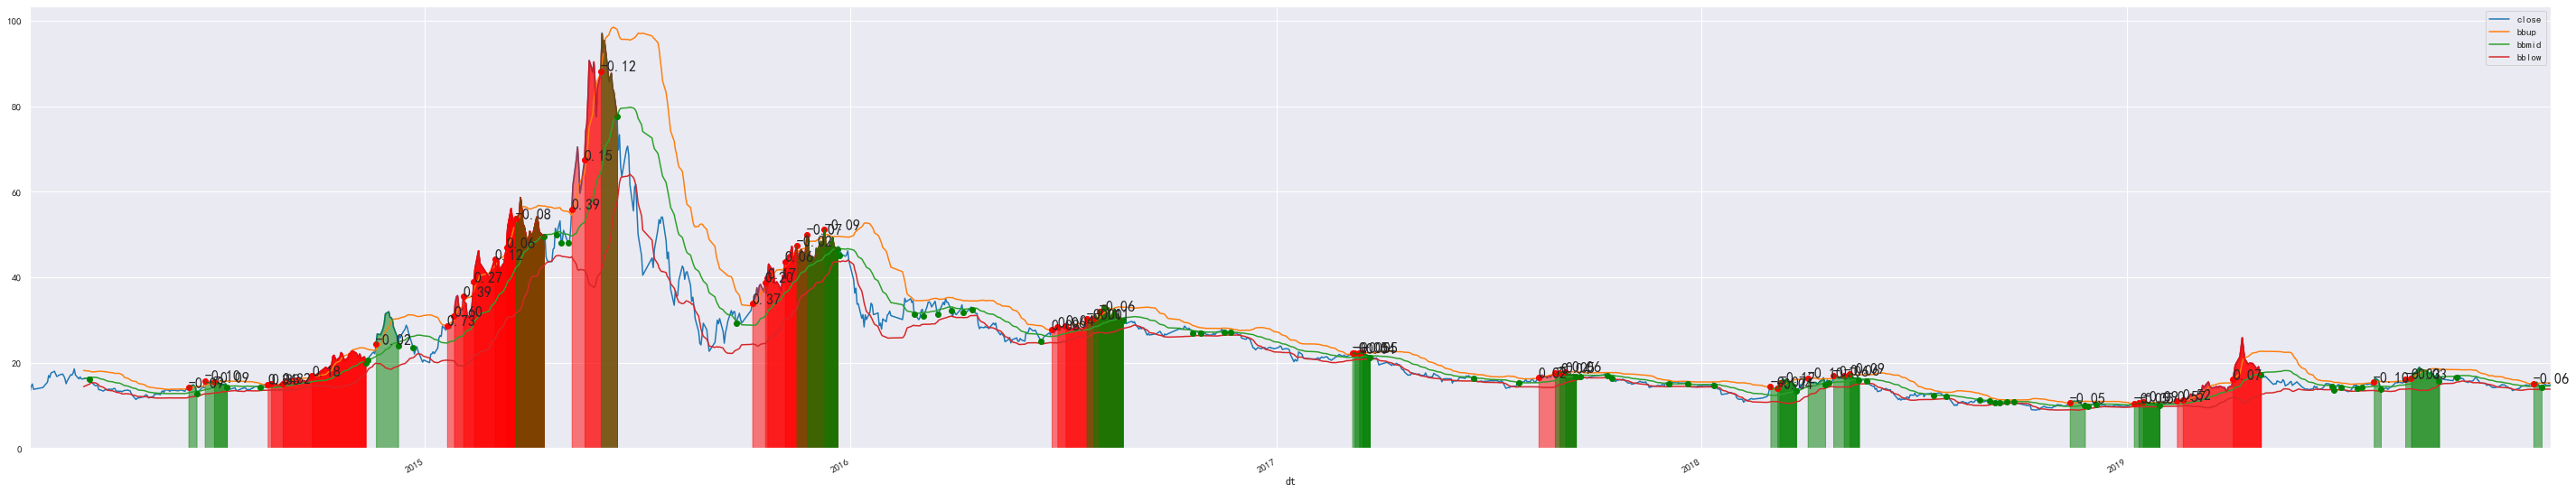

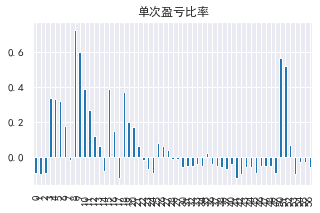

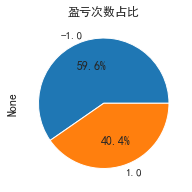

盈利交易平均盈利比率:26.25%
最大盈利比率:72.69%
亏损交易平均亏损比率:-6.18%
最大亏损比率:-12.46%
平均:6.90%
交易次数:57


In [206]:
simple_data=KLManager(benchmark,capital).get_pick_time_kl_pd('300378')
# 收盘价上穿布林带上轨
simple_data['buy']=QA.QAIndicator.CROSS(simple_data['close'],simple_data['bbup'])
# 收盘价下穿布林带中轨
simple_data['sell']=QA.QAIndicator.CROSS(simple_data['bbmid'],simple_data['close'])
simple_test(simple_data)